# <p style="text-align: center;">EE 379K: Data Science Lab</p>
# <p style="text-align: center;">Lab 6 - 10/16/17</p>
## <p style="text-align: center;">Rachel Chen and Kevin Yee</p>
### <p style="text-align: center;"> rjc2737 and kjy252</p>

#Problem 1 
In this problem we will use synthetic data sets to explore the bias-variance tradeoffincurred by using regularization.

* Generate data of the form: 
$$ y = X\beta + \epsilon $$ 

where X is an n x p matrix where n = 51, p = 50, and each $X_{ij} \sim N(0,1)$. Also, generate the noise according to $\epsilon_i \sim N(0,1/4)$. Let $\beta$ be the all ones vector for simplicity.

By repeatedly doing the experiment and generating fresh data (fresh X, and y, and hence $\epsilon$ but keeping $\beta$ fixed, you will estimate many diffferent solutions, $\hat{\beta}$. Estimate the mean and variance of $\hat{\beta}$. Note that $\hat{\beta}$ is a vector, so for this exercise simply estimate the variance of a single component.


* Use ridge regression i.e. $l_2$ regularization. Vary the regularization coefficient $\lambda = 0.01, 0.1, 1, 10, 100$ and repeat the above experiment. What do you observe? As you increase $\lambda$ is the model becoming more simple or more complex? As you increase $\lambda$ is performance becoming better or worse? 

#Answer

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
#generate data
X = np.random.normal(0,1, size = (51,50))
e = np.random.normal(0,.25)
beta = np.ones((51,50))

#Create OLS unbiased model to estiamte beta hat 
linear = LinearRegression()

#Compute y
y = X.dot(beta.T) + e

#Compute coefficient with Linear regression model: 
linear.fit(X,y)

mean = []
var = []
for i in range(1,1000):
    X = np.random.normal(0,1, size = (51,50))
    e = np.random.normal(0,.25)
    y = X.dot(beta.T) + e
    linear.fit(X,y)
    mean.append(np.mean(linear.coef_))
    var.append(np.var(linear.coef_))
    
print "Ordinary Least Squares:"
print " Mean of beta hat using OLS: " + str(np.mean(mean))
print " Variance of beta hat using OLS: " + str(np.mean(var))

alphas = [0.01, 0.1, 1, 10, 100]
print "\nRidge Regression:"
for alpha in alphas:
    ridge = Ridge(alpha = alpha).fit(X,y)
    print
    print "lambda = " + str(alpha)
    print " Mean of beta hat using Ridge: " + str(np.mean(ridge.coef_))
    print " Variance of beta hat using Ridge: "+ str(np.var(ridge.coef_))

Ordinary Least Squares:
 Mean of beta hat using OLS: 1.0
 Variance of beta hat using OLS: 1.92053666867e-26

Ridge Regression:

lambda = 0.01
 Mean of beta hat using Ridge: 0.943064075103
 Variance of beta hat using Ridge: 0.0366113509967

lambda = 0.1
 Mean of beta hat using Ridge: 0.889889203338
 Variance of beta hat using Ridge: 0.0659038736155

lambda = 1
 Mean of beta hat using Ridge: 0.793002172341
 Variance of beta hat using Ridge: 0.11204086511

lambda = 10
 Mean of beta hat using Ridge: 0.608730650802
 Variance of beta hat using Ridge: 0.117441818004

lambda = 100
 Mean of beta hat using Ridge: 0.261882902213
 Variance of beta hat using Ridge: 0.0447470897779


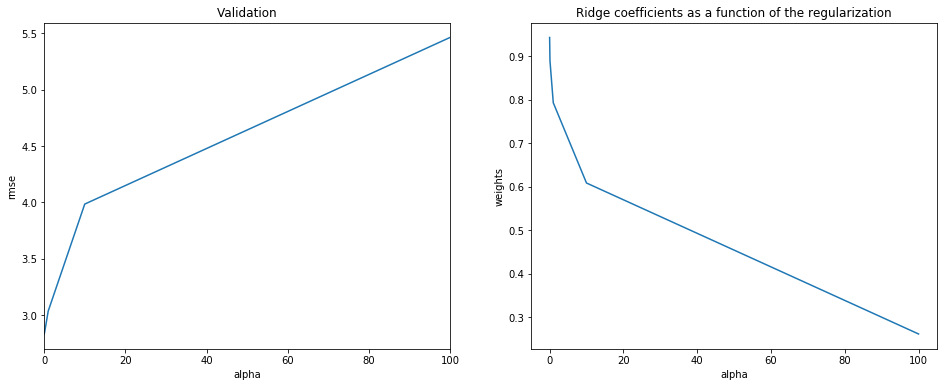

In [4]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)


alphas = [0.01, 0.1, 1, 10, 100]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

coefs = [Ridge(alpha = alpha).fit(X,y).coef_.mean() for alpha in alphas]

plt.figure(figsize=(16,6))
plt.subplot(121)
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

plt.subplot(122)
plt.plot(alphas,coefs)
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')


From the figure comparing alpha and rmse, the model is getting increasingly worse as alpha is increasing

From the figure comparing alpha and weights, the model is getting increasingly simpler as the weights of $\hat{\beta}$ decreases


# Problem 2 
Problem 9 from Chapter 6.
(Predicting  the  number  of  applications  in  College)  Note  that  you  will  have  to  read  about  PCR(Principal Components Regression) and PLS (Partial Least Squares ) in the book, since we did not discuss these in class.

![](http://i.markdownnotes.com/image_7m46Jzg.png)

#Answer

In [206]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.cross_validation import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import cross_validation
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [207]:
college = pd.read_csv("Data/College.csv")

#split data up
y = college.Apps
X = college.drop('Apps',axis = 1)
X['Private'] = X['Private'].replace('Yes',1).replace('No',0)
X = X.loc[:, "Private":]
X.head()

#split data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=20)


#iniatlize models 
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
ols = LinearRegression()
ridgeCV = RidgeCV(alphas=alphas, cv=10)
lassoCV = LassoCV(alphas=alphas, cv=10, max_iter=10000)

# Least Squares
ols.fit(X_train, y_train)
olsmse = mean_squared_error(y_test, ols.predict(X_test))

print "OLS Linear Regression MSE: " + str(olsmse)

# RidgeCV 
ridgeCV.fit(X_train, y_train)
ridgemse = mean_squared_error(y_test, ridgeCV.predict(X_test))
                  
print "Ridge Regression MSE: " + str(ridgemse)
# LassoCV
lassoCV.fit(X_train, y_train)
lassomse = mean_squared_error(y_test, lassoCV.predict(X_test))
                  
print "Lasso Regression MSE: " + str(lassomse)
print "Lasso, Non Zero Coefficients", len(lassoCV.coef_.nonzero()[0])

OLS Linear Regression MSE: 788016.339525
Ridge Regression MSE: 788849.335783
Lasso Regression MSE: 789339.4189
Lasso, Non Zero Coefficients 17


[  31.54   57.04   64.04   69.86   75.44   80.48   84.15   87.57   90.6
   93.03   95.05   96.85   97.95   98.74   99.37   99.84  100.01]


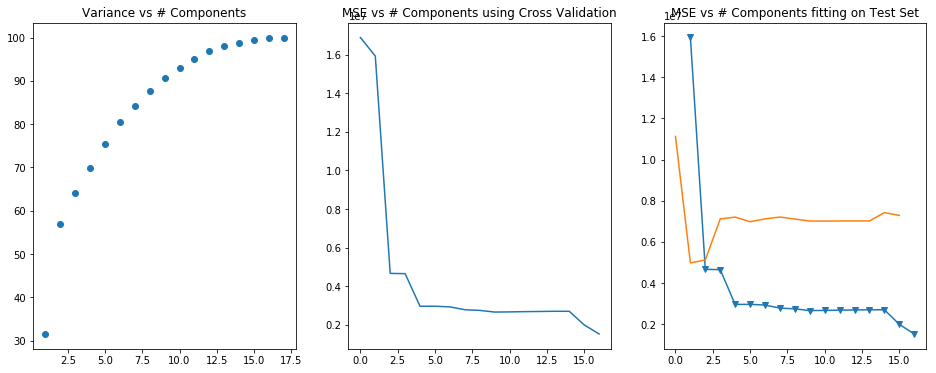

In [209]:
# https://stats.stackexchange.com/questions/82050/principal-component-analysis-and-regression-in-python
#PCR
pca = PCA()
pc_train_x = pca.fit_transform(scale(X_train))
pc_test_x = pca.fit_transform(scale(X_test))


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))

#Plot Expalained Variance to determine best components
pc_train_x = pca.fit_transform(scale(X_train))
ax1.set_title("Variance vs # Components")
xVals = [n for n in range(1,len(X_train.columns)+1)]
explainedVar = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print explainedVar
ax1.scatter(xVals,explainedVar)



mse = []
linearpcr = LinearRegression()


#Find number of components using cross validation mse scores
#Zero Components
mse.append(np.mean(-1 * cross_val_score(linearpcr, np.ones((len(pc_train_x), 1)),
                                        y_train, cv=20, scoring='neg_mean_squared_error')))

#One to Ten Components
for i in range(1, len(X_train.columns)):
    mse.append(np.mean(-cross_val_score(linearpcr, pc_train_x[:, :i], y_train, cv=10,
                                    scoring='neg_mean_squared_error')))
    
#Plot MSE to determine best components
ax2.plot(mse)
ax2.set_title("MSE vs # Components using Cross Validation")

#Plot disregarding intercept
ax3.plot([n for n in range(1,len(X_train.columns))], mse[1:],'-v')

pcamse = []
for i in range(1,len(X_train.columns)):
    linearpcr.fit(pc_train_x[:, :i], y_train)
    pcamse.append(mean_squared_error(y_test, linearpcr.predict(pc_test_x[:,:i])))
    
ax3.plot(pcamse)
ax3.set_title("MSE vs # Components fitting on Test Set")

linearpcr.fit(pc_train_x[:, 0:9], y_train)
pcrmse = mean_squared_error(y_test, linearpcr.predict(pc_test_x[:,0:9]))

In [64]:
print "The minimum MSE obtained is with 17 components with an MSE of: " + str(min(mse))
print "The MSE obtained with 10 components is: "+str(mse[9])+" which explains about: "+str(explainedVar[9])+" percent of variance"

print "PCR Regression MSE on Test set: " + str(pcrmse)

The minimum MSE obtained is with 17 components with an MSE of: 1527014.99208
The MSE obtained with 10 components is: 2663349.37745 which explains about: 93.03 percent of variance
PCR Regression MSE on Test set: 7108876.60507


Using cross-validation of the training set with a PCR model, we recognize that 17 components produces the lowest of MSE of ~1500000. 

However, this makes the purpose of PCR pointless. We recognize that 10 components, achieves 93% of variance (about 1/2 of the features can explain the variance of the data set).
Using M = 10, we get a MSE of ~2660000.

When running the model on the test set, we saw that 3 components performed the best (orange line in figure 3).


The lowest MSE obtained is: 1454598.72511 with 13 components


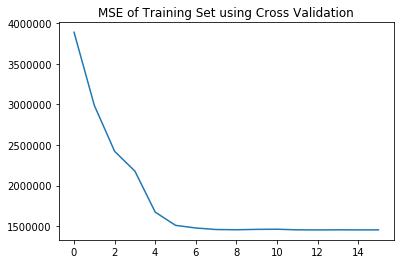

In [103]:
# Using PLS 
# http://www.mathstat.dal.ca/~aarms2014/StatLearn/assignments/A3sol_2.pdf
# https://rpubs.com/ppaquay/65562
mse = []
mse.append(0);
for i in range(1, len(X_train.columns)):    
    plsReg = PLSRegression(n_components=i)
    mse.append(np.mean(-cross_val_score(plsReg, scale(X_train), y_train, cv=10,
                                    scoring='neg_mean_squared_error')))

    #print "Number of Components: ", i, "MSE Score: ", mse[i]


plt.plot(mse[1:])
plt.title("MSE of Training Set using Cross Validation")

print "\nThe lowest MSE obtained is:",str(min(mse[1:])), "with",str(mse.index(min(mse[1:]))), "components"

In [104]:
plsReg = PLSRegression(n_components = 10)
plsReg.fit(scale(X_train),y_train)
plsmse = mean_squared_error(y_test,plsReg.predict(scale(X_test)))
print "PLS Regression MSE on Test set: " + str(plsmse)

PLS Regression MSE on Test set: 1991779.47678


Using, PLS, we observe that the minimum component obtained is with M = 9 components with an MSE of ~1400000.

In [105]:
print "MSE"
print "OLS Linear Regression MSE: " + str(olsmse)
print "Ridge Regression MSE: " + str(ridgemse)
print "Lasso Regression MSE: " + str(lassomse)
print "PCR Regression MSE on Test set: " + str(pcrmse)
print "PLS Regression MSE on Test set: " + str(plsmse)

print "\nR^2 Scores"
print "OLS R^2 Score:" + str(ols.score(X_test,y_test))
print "Ridge R^2 Score:" + str(ridgeCV.score(X_test,y_test))
print "Lasso R^2 Score:" + str(lassoCV.score(X_test,y_test))
print "PCR R^2 Score:" + str(linearpcr.score(pc_test_x[:, 0:9],y_test))
print "PLS R^2 Score: " + str(plsReg.score(scale(X_test),y_test))

MSE
OLS Linear Regression MSE: 788016.339525
Ridge Regression MSE: 788849.335783
Lasso Regression MSE: 789339.4189
PCR Regression MSE on Test set: 7108876.60507
PLS Regression MSE on Test set: 1991779.47678

R^2 Scores
OLS R^2 Score:0.913122839795
Ridge R^2 Score:0.913031003693
Lasso R^2 Score:0.91297697305
PCR R^2 Score:0.216261160186
PLS R^2 Score: 0.780410461031


Ordinary Least Squares, Ridge, and Lasso seem to do a decent job in predicting the test set with R^2 values of approximately 91% 

However, PLS has an R^2 value of 78% (slightly worse). Even though the MSE on the test set was small, the R^2 value was rather poor.

PCR Regression has the worst prediction power .

# Problem 3

![](http://i.markdownnotes.com/image_9kryzAh.png)

In [240]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score

In [241]:
boston = pd.read_csv("Data/boston.csv")

In [242]:
X = boston.drop('crim', axis = 1)
y = boston.crim
X.head()

,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [243]:
lambdas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

#Linear
print "  Linear Model Using Least Squares"
olslinear = LinearRegression()
olslinear.fit(x_train, y_train)
y_pred = olslinear.predict(x_test)
MSE = mean_squared_error(y_test, y_pred)
TMSE = mean_squared_error(y_train, olslinear.predict(x_train))
CVS = np.mean(-cross_val_score(olslinear, x_train, y_train, cv=20, scoring='neg_mean_squared_error'))
print "    test error:", MSE
print "    training error:", TMSE
print "    cross-validation error:", CVS

#Ridge
print "  Ridge Regression"
ridgecv = RidgeCV(alphas = lambdas, cv = 10)
ridgecv.fit(x_train, y_train)
y_pred = ridgecv.predict(x_test)
MSE = mean_squared_error(y_test, y_pred)
TMSE = mean_squared_error(y_train, ridgecv.predict(x_train))
CVS = np.mean(-cross_val_score(ridgecv, x_train, y_train, cv=20, scoring='neg_mean_squared_error'))
print "    test error:", MSE
print "    training error:", TMSE
print "    cross-validation error:", CVS

#Lasso
print "  Lasso Regression"
lassocv = LassoCV(alphas = lambdas, cv = 10)
lassocv.fit(x_train, y_train)
y_pred = lassocv.predict(x_test)
MSE = mean_squared_error(y_test, y_pred)
TMSE = mean_squared_error(y_train, lassocv.predict(x_train))
CVS = np.mean(-cross_val_score(lassocv, x_train, y_train, cv=20, scoring='neg_mean_squared_error'))
print "    test error:", MSE
print "    training error:", TMSE
print "    cross-validation error:", CVS

  Linear Model Using Least Squares
    test error: 18.7649000218
    training error: 46.2363379409
    cross-validation error: 50.824744187
  Ridge Regression
    test error: 16.424851714
    training error: 47.5049899913
    cross-validation error: 50.7041695945
  Lasso Regression
    test error: 18.0534897577
    training error: 46.7679120818
    cross-validation error: 50.9537634938


[ 45.77  61.05  69.89  77.25  83.32  88.34  91.58  93.93  95.94  97.52
  98.69  99.64  99.98]
PCA MSE: 120.858046224


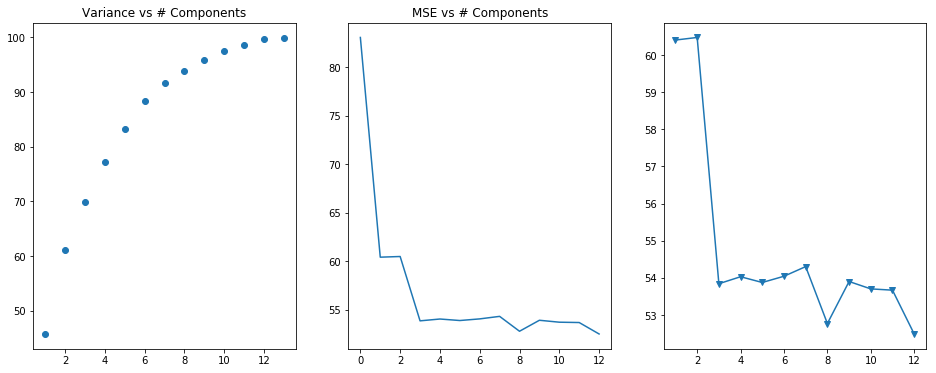

In [244]:
pca = PCA()
pc_train_x = pca.fit_transform(scale(x_train))
pc_test_x = pca.fit_transform(scale(x_test))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))

#Plot Explained Variance to determine best components
ax1.set_title("Variance vs # Components")
xVals = [n for n in range(1,len(x_train.columns)+1)]
explainedVar = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print explainedVar
ax1.scatter(xVals,explainedVar)

mse = []
plinear = LinearRegression()

#Find number of components using cross validation mse scores
#Zero Components
mse.append(np.mean(-cross_val_score(plinear, np.ones((len(pc_train_x), 1)),
                                        y_train, cv=10, scoring='neg_mean_squared_error')))

#One to Ten Components
for i in range(1, len(x_train.columns)):
    mse.append(np.mean(-cross_val_score(plinear, pc_train_x[:, :i], y_train, cv=10,
                                    scoring='neg_mean_squared_error')))
#Plot MSE to determine best components
ax2.plot(mse)
ax2.set_title("MSE vs # Components")

#Plot disregarding intercept
ax3.plot([n for n in range(1,len(x_train.columns))],mse[1:],'-v')

plinear.fit(pc_train_x, y_train)
pcamse = mean_squared_error(y_test, plinear.predict(pc_test_x))

print "PCA MSE: " + str(pcamse)
pcrmse = mean_squared_error(y_test, plinear.predict(pc_test_x[:,0:len(x_train.columns)]))

In [245]:
print "The minimum MSE obtained is with 13 components with an MSE of: " + str(min(mse)) + " which explains about: "+str(explainedVar[9])+" percent of variance"


print "PCR Regression MSE on Test set: " + str(pcrmse)

The minimum MSE obtained is with 13 components with an MSE of: 52.4880808697 which explains about: 97.52 percent of variance
PCR Regression MSE on Test set: 120.858046224


In [246]:
print "\nR^2 Scores"
print "OLS R^2 Score: " + str(olslinear.score(x_test,y_test))
print "Ridge R^2 Score: " + str(ridgecv.score(x_test,y_test))
print "Lasso R^2 Score: " + str(lassocv.score(x_test,y_test))
print "PCR R^2 Score: " + str(plinear.score(pc_test_x[:, 0:len(x_train.columns)],y_test))


R^2 Scores
OLS R^2 Score: 0.502113324776
Ridge R^2 Score: 0.564201525111
Lasso R^2 Score: 0.520989081679
PCR R^2 Score: -2.20671097308


## Analysis:
   
When comparing the test errors of the linear, ridge, lasso, and PCR, PCR faired the worst, with a MSE of 120.85 compared to the 18.76, 16.42, and 18.05 of linear, ridge, and lasso respectively. When looking that the latter three, ridge regression performs the best on test error, training error, and cross-validation error.

However, these measures can only tell us so much. Using R^2 scores as another metric, ridge regression also has the highest score.

Just as means of a sanity check, let's perform feature reduction on 9 components, the number of components that yielded the second lowest MSE from PCR.

In [247]:
from sklearn import datasets
from sklearn.feature_selection import RFE

lambdas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

olslinear = LinearRegression()
# create the RFE model and select 3 attributes
olsrfe = RFE(olslinear, 9)
olsrfe = olsrfe.fit(x_train, y_train)
# summarize the selection of the attributes
print(olsrfe.support_)
print(olsrfe.ranking_)


ridgecv = RidgeCV(alphas = lambdas, cv = 10)
# create the RFE model and select 3 attributes
ridgerfe = RFE(ridgecv, 9)
ridgerfe = ridgerfe.fit(x_train, y_train)
# summarize the selection of the attributes
print(ridgerfe.support_)
print(ridgerfe.ranking_)

lassocv = LassoCV(alphas = lambdas, cv = 10)
# create the RFE model and select 3 attributes
lassorfe = RFE(lassocv, 9)
lassorfe = lassorfe.fit(x_train, y_train)
# summarize the selection of the attributes
print(lassorfe.support_)
print(lassorfe.ranking_)

print "average rfe"
print (np.asarray(olsrfe.ranking_) + np.asarray(ridgerfe.ranking_) + np.asarray(lassorfe.ranking_))/3

[False  True  True  True  True False  True  True False  True False  True
  True]
[2 1 1 1 1 3 1 1 4 1 5 1 1]
[ True  True  True False  True False  True  True False  True False  True
  True]
[1 1 1 4 1 2 1 1 5 1 3 1 1]
[ True  True False False  True False  True  True False  True  True  True
  True]
[1 1 5 4 1 3 1 1 2 1 1 1 1]
average rfe
[1 1 2 3 1 2 1 1 3 1 3 1 1]


So it looks like the top features are 0, 1, 2, 4, 6, 7, 9, 11, 12. Let's drop the other columns and run the same tests on the linear, ridge, and lasso models with the top 9 features.

In [ ]:
Xnew = X.drop(['nox', 'age', 'tax', 'black'], axis=1)
Xnew.head()

,zn,indus,chas,rm,dis,rad,ptratio,lstat,medv
0,18.0,2.31,0,6.575,4.0900,1,15.3,4.98,24.0
1,0.0,7.07,0,6.421,4.9671,2,17.8,9.14,21.6
2,0.0,7.07,0,7.185,4.9671,2,17.8,4.03,34.7
3,0.0,2.18,0,6.998,6.0622,3,18.7,2.94,33.4
4,0.0,2.18,0,7.147,6.0622,3,18.7,5.33,36.2


In [ ]:
lambdas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

x_train, x_test, y_train, y_test = train_test_split(Xnew, y, test_size = 0.2, random_state=10)

#Linear
print "  Linear Model Using Least Squares"
olslinear = LinearRegression()
olslinear.fit(x_train, y_train)
y_pred = olslinear.predict(x_test)
MSE = mean_squared_error(y_test, y_pred)
TMSE = mean_squared_error(y_train, olslinear.predict(x_train))
CVS = np.mean(-cross_val_score(olslinear, x_train, y_train, cv=20, scoring='neg_mean_squared_error'))
print "    test error:", MSE
print "    training error:", TMSE
print "    cross-validation error:", CVS

#Ridge
print "  Ridge Regression"
ridgecv = RidgeCV(alphas = lambdas, cv = 10)
ridgecv.fit(x_train, y_train)
y_pred = ridgecv.predict(x_test)
MSE = mean_squared_error(y_test, y_pred)
TMSE = mean_squared_error(y_train, ridgecv.predict(x_train))
CVS = np.mean(-cross_val_score(ridgecv, x_train, y_train, cv=20, scoring='neg_mean_squared_error'))
print "    test error:", MSE
print "    training error:", TMSE
print "    cross-validation error:", CVS

#Lasso
print "  Lasso Regression"
lassocv = LassoCV(alphas = lambdas, cv = 10)
lassocv.fit(x_train, y_train)
y_pred = lassocv.predict(x_test)
MSE = mean_squared_error(y_test, y_pred)
TMSE = mean_squared_error(y_train, lassocv.predict(x_train))
CVS = np.mean(-cross_val_score(lassocv, x_train, y_train, cv=20, scoring='neg_mean_squared_error'))
print "    test error:", MSE
print "    training error:", TMSE
print "    cross-validation error:", CVS

#nzc = np.count_nonzero(lassocv.coef_)

#print "    number of non-zero coeff:", nzc

  Linear Model Using Least Squares
    test error: 19.5183262327
    training error: 46.8617563914
    cross-validation error: 49.4753999247
  Ridge Regression


In [ ]:
print "\nR^2 Scores"
print "OLS R^2 Score: " + str(olslinear.score(x_test,y_test))
print "Ridge R^2 Score: " + str(ridgecv.score(x_test,y_test))
print "Lasso R^2 Score: " + str(lassocv.score(x_test,y_test))

## More Analysis:

Trying out the linear, ridge, and lasso regressions with the modified data set of 9 features yielded results that were not better than the full set of 13 features, as to be expected since the PCR with 13 components produced the lowest MSE error. Test, training, and cross-validation errors were all higher with 9 components and the R^2 scores were not lower.

Thus the best model is ridge regression with all 13 features.

# Problem 4

**Ordinary Least Squares:**

$$min_\beta: ||X\beta -y||_2^2 = \sum(X_i\beta-y_i)^2$$
1. Vector Notation. Derive and Set to Zero.
$$2X^T(X\beta-y) = 0 $$ 


2. 
$$~$$
$$2X^TX\beta - 2X^Ty = 0 $$
$$~$$
$$ X^T X \beta = X^T y $$
$$~$$
$$ \hat{\beta} = (X^TX)^-1X^Ty$$


**Ridge Regression:**
$$min_\beta: ||X\beta -y||_2^2 + \lambda ||\beta||^2_2= \sum(X_i\beta-y_i)^2 + \lambda \sum \beta_i^2$$

1. Make Vector Notation, Derive and set to zero

$$2X^T(X\beta-y) + 2\lambda \beta = 0 $$ 

 
2. 
$$2X^TX\beta-2X^Ty + 2\lambda\beta =0$$
$$~$$
$$ X^T X \beta + \lambda\beta = X^T y $$
$$~$$
$$(X^TX + \lambda I)\beta = X^Ty$$
$$~$$
$$\hat{\beta} = (X^TX + \lambda I)^{-1}X^Ty$$